In [ ]:
# Kullanılacak kütüphaneleri yükleyelim:
# !pip3 install datasets
# !pip install transformers
# !pip install transformers[torch]
# !pip install accelerate -U
# !pip install evaluate
# !pip install scikit-learn

In [4]:
from google.colab import drive
import os
import copy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import torch
from datasets import load_dataset, Image, load_from_disk
from transformers import (ViTFeatureExtractor,
                          ViTForImageClassification,
                          TrainingArguments,
                          TrainerCallback,
                          Trainer,
                          AutoModelForImageClassification,
                          AutoFeatureExtractor)
import evaluate
from huggingface_hub import notebook_login, create_repo


Öncelikle Google Drive'ı Colab'a bağlayalım. Google Drive'ınızın tamamını Colab'a bağlamak için `google.colab` kütüphanesindeki `drive` modülünü kullanabilirsiniz:

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Google Hesabınıza erişim izni verdikten sonra Drive'a bağlanabilirsiniz.

Drive bağlandıktan sonra `"Mounted at /content/gdrive"` mesajını alırsınız ve dosya gezgini bölmesinden Drive'ınızın içeriğine göz atabilirsiniz.

In [6]:
!pwd

/content


İlk olarak `os` kütüphanesini kullanarak `project` isimli klasörü Drive'da yaratalım.

In [9]:
path = "./gdrive/MyDrive/project"
os.mkdir(path)

Artık `project` klasörüne yarattığımıza göre, geçerli çalışma dizinini (current working directory) bu klasöre taşıyalım:

In [10]:
os.chdir('./gdrive/MyDrive/project')


# Veri Kümesi

Bilgisayar kullanımıyla hastalıkların otomatik tespiti önemli ancak henüz keşfedilmemiş bir araştırma alanıdır. Bu tür yenilikler tüm dünyada tıbbi uygulamaları iyileştirebilir ve sağlık bakım sistemlerini iyileştirebilir. Bununla birlikte, tıbbi görüntüleri içeren veri kümeleri neredeyse hiç mevcut değildir, bu da yaklaşımların tekrarlanabilirliğini ve karşılaştırılmasını neredeyse imkansız hale getirmektedir.

Bu nedenle burada, tıp doktorları (deneyimli endoskopistler) tarafından etiketlenmiş ve doğrulanmış, gastrointestinal (gastrointestinal) sistemin içinden görüntülerden oluşan Kvasir veri kümesinin 2. versiyonunu (`kvasir-dataset-v2`) kullanacağız.

Kvasir veri kümesi yaklaşık 2.3GB büyüklüğündedir ve yalnızca araştırma ve eğitim amaçlı kullanılmak suretiyle ücretsizdir: https://datasets.simula.no/kvasir/

Veri kümesi, her biri 1.000 görüntüye sahip olan 8 sınıftan, yani toplam 8.000 görüntüden oluşmaktadır.

![](https://github.com/mmuratarat/turkish/blob/master/_posts/images/kvasir_v2_examples.png?raw=true)

Bu sınıflar **patolojik bulgular** (özofajit, polipler, ülseratif kolit), **anatomik işaretler** (z-çizgisi, pilor, çekum) ve **normal ve düzenli bulgular** (normal kolon mukozası, dışkı) ve **polip çıkarma vakalarından** (boyalı ve kaldırılmış polipler, boyalı rezeksiyon kenarları) oluşmaktadır

JPEG görüntüleri ait oldukları sınıfa göre adlandırılan ayrı klasörlerde saklanmaktadır.

Veri seti, $720 \times 576$'dan $1920 \times 1072$ piksele kadar farklı çözünürlükteki görüntülerden oluşur ve içeriğe göre adlandırılmış ayrı klasörlerde sıralanacak şekilde düzenlenmiştir.

Şimdi yukarıdaki websayfasında bulunan ve görüntüleri içeren `kvasir-dataset-v2.zip` isimli zip dosyasını indirelim:

In [13]:
!wget https://datasets.simula.no/downloads/kvasir/kvasir-dataset-v2.zip

--2023-10-04 08:44:25--  https://datasets.simula.no/downloads/kvasir/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  14.4MB/s    in 2m 34s  

2023-10-04 08:47:00 (15.4 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



İndirme tamamlandıktan sonra, bu zip dosyasını unzip'leyelim ve görüntü verilerimizi elde edelim:

In [ ]:
!unzip kvasir-dataset-v2.zip

zip dosyasıyla işimiz bittiği için yer kaplamaması için silelim:

In [15]:
!rm -rf kvasir-dataset-v2.zip

Daha sonra `kvasir-dataset-v2` isimli dosyayı `image_data` olarak yeniden isimlendirelim:

In [16]:
os.rename('kvasir-dataset-v2', 'image_data')

Son durumda görüntülerden oluşan veri kümesi yapımız şu şekilde görünmektedir:

```
image_data/dyed-lifted-polyps/0a7bdce4-ac0d-44ef-93ee-92dfc8fe0b81.jpg
image_data/dyed-lifted-polyps/0a7ece5b-caaa-496e-9e6e-0c7eab171527.jpg
...
image_data/dyed-resection-margins/0a0b455d-d3dd-4be4-a6a3-90f81d8c8f36.jpg
image_data/dyed-resection-margins/0a2a2f35-c798-447c-a883-8f2f448bfe07.jpg
...
image_data/ulcerative-colitis/00a436bc-67ee-4a43-b1a7-25130a2d4e72.jpg
image_data/ulcerative-colitis/cat/0aacb7fa-19fb-4bd6-9a43-3c0a246e7a58.jpg
```

Bu özel (custom) veri kümesini HuggingFace ortamına yüklemek için ` datasets`  modülündeki ` load_dataset`  fonksiyonunu kullanabilirsiniz.

In [17]:
full_dataset = load_dataset("imagefolder", data_dir="./image_data", split="train")

Resolving data files:   0%|          | 0/8000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [18]:
full_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 8000
})

Veri kümesinde 8000 satır olduğunu (çünkü 8000 görüntü var) ve görüntülerin etiketlerinin (`label`) otomatik oluşturulduğunu kolaylıkla görebilirsiniz.

In [19]:
full_dataset.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis'], id=None)}

In [20]:
labels = full_dataset.features['label']
labels

ClassLabel(names=['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis'], id=None)

Spesifik bir görüntüye ulaşmak da oldukça kolaydır. Yapmanız gereken bir indeks kullanmaktır. Veri kümesindeki ilk görüntüye ulaşalım:

In [21]:
full_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x576>,
 'label': 0}

Bu görüntününün moduna ve etiketine de kolaylıkla erişilebilir:

In [22]:
full_dataset[0]['image'].mode

'RGB'

In [23]:
full_dataset[0]['label'], labels.names[full_dataset[0]['label']]

(0, 'dyed-lifted-polyps')

İlk olarak etiketler ve bu etiketlere ait id'leri (numaraları) içerisinde tutan iki sözlük (dictionary) oluşturalım:

In [24]:
id2label = {str(i): label for i, label in enumerate(labels.names)}
print(id2label)

{'0': 'dyed-lifted-polyps', '1': 'dyed-resection-margins', '2': 'esophagitis', '3': 'normal-cecum', '4': 'normal-pylorus', '5': 'normal-z-line', '6': 'polyps', '7': 'ulcerative-colitis'}


In [25]:
label2id = {v: k for k, v in id2label.items()}
print(label2id)

{'dyed-lifted-polyps': '0', 'dyed-resection-margins': '1', 'esophagitis': '2', 'normal-cecum': '3', 'normal-pylorus': '4', 'normal-z-line': '5', 'polyps': '6', 'ulcerative-colitis': '7'}


`datasets` modülünde bulunan `Image` fonksiyonu, bir görüntü nesnesini döndürmek için `image` sütunundaki verilerin kodunu otomatik olarak çözer. Şimdi görselin ne olduğunu görmek için `image` sütununu çağırmayı deneyiniz

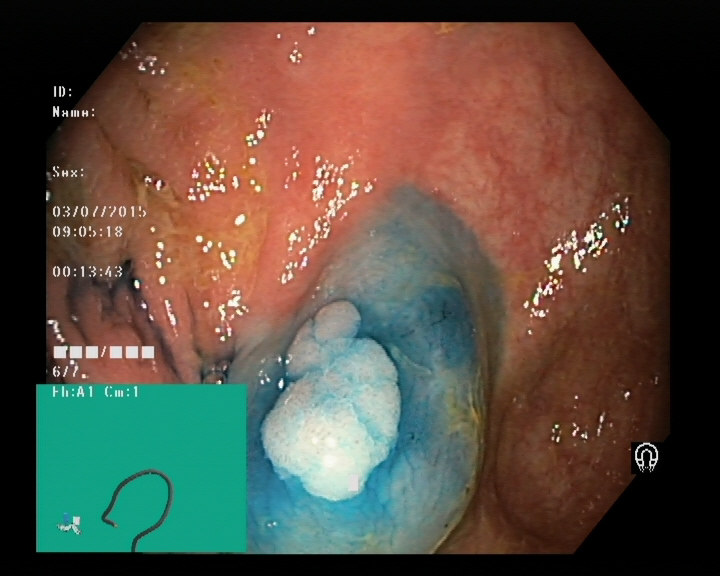

In [26]:
full_dataset[0]["image"]

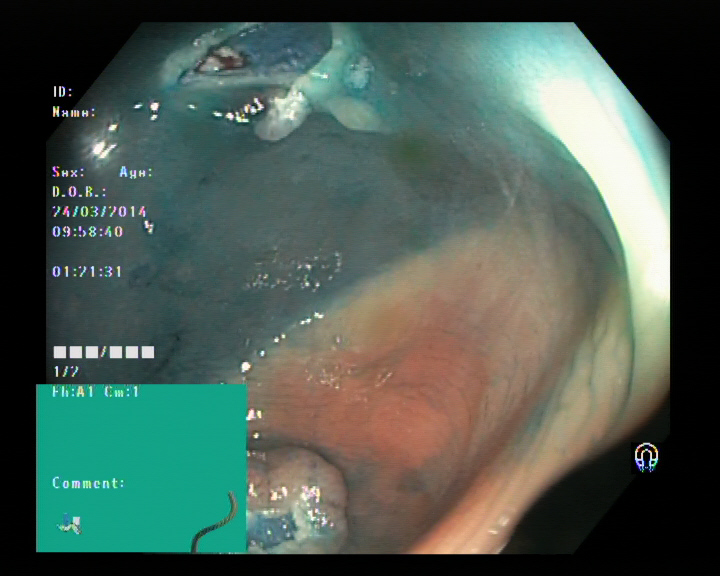

In [27]:
full_dataset[1000]["image"]

Burada görüntü sınıflandırma (image classification) görevini gerçekleştireceğiz. Veri kümesinde 8 farklı sınıf var. Bu nedenle çok-sınıflı sınıflandırma (multi-class classification) problemi ile karşı karşıyayız. 

Çok-sınıflı görüntü sınıflandırma problemi için önceden-eğitilmiş (pre-trained) bir modele ihtiyacımız var. HuggingFace Hub'da görüntü sınıflandırma için oldukça fazla önceden-eğitilmiş model bulabilirsiniz - https://huggingface.co/models?pipeline_tag=image-classification&sort=downloads&library=pytorch

Görüntü sınıflandırma için transfer öğrenmenin arkasındaki sezgi, eğer bir model yeterince geniş ve genel bir veri kümesi üzerinde eğitilirse, bu model etkili bir şekilde görsel dünyanın genel bir modeli olarak hizmet edebilir. Daha sonra büyük bir modeli büyük bir veri kümesi üzerinde eğiterek sıfırdan başlamanıza gerek kalmadan bu öğrenilen özellik haritalarından (feature maps) yararlanabilirsiniz.

Birçok görevde bu yaklaşım, hedeflenen verileri kullanarak bir modeli sıfırdan eğitmekten daha iyi sonuçlar vermiştir.

Artık ihtiyaçlarımıza uyacak şekilde ince ayar yapacağımız temel modelimizi seçebiliriz.

Burada Visual Transformer (ViT) denilen bir görsel transformer modelini kullanacağız (https://huggingface.co/google/vit-base-patch16-224). 

ViT, "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" isimli makalede 2021 yılında Dosovitskiy ve arkadaşları tarafından tanıtılmıştır. ViT modeli ImageNet-21k (14 milyon görüntü, 21.843 sınıf) veri kümesi üzerinde önceden eğitilmiş ve ImageNet 2012 (1 milyon görüntü, 1.000 sınıf) veri kümesi üzerinde ince ayar çekilmiştir. Girdi görüntüleri  $224 x 224$ çözünürlüğe sahiptir. Genel olarak üç tür ViT modeli vardır:

* ViT-base: 12 katmana, 768 gizli boyuta ve toplam 86M parametreye sahiptir.
* ViT-large: 24 katmana, 1024 gizli boyuta ve toplam 307M parametreye sahiptir.
* ViT-huge: 32 katmanı, 1280 gizli boyutu ve toplam 632M parametresi vardır.

![](https://github.com/mmuratarat/turkish/blob/master/_posts/images/Screenshot%202023-10-04%20at%205.17.43%20PM.png?raw=true)

Bu tutorial için Hugging Face'te bulunan [the google/vit-base-patch16-224-in21k model](https://huggingface.co/google/vit-base-patch16-224-in21k) modelini kullanacağız.

İlk olarak biraz veri temizliği yapalım ve RGB olmayan (tek kanallı, gri tonlamalı) görüntüleri veri kümesinden kaldıralım:

In [28]:
# Remove from dataset images which are non-RGB (single-channel, grayscale)
condition = lambda data: data['image'].mode == 'RGB'
full_dataset = full_dataset.filter(condition)
full_dataset

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 8000
})

Görüntülerin hepsi üç kanallı, yani RGB modundadır. Bu nedenle herhangi bir filtreleme işlemi gerçekleşmemiştir.

# Veri kümesini eğitim/test olarak parçalamak

Modeli seçtiğimizde göre ilk olarak yapmamız gereken veri kümesini eğitim (train) ve test olacak şekilde ikiye parçalamak. Bunun için `train_test_split()` fonksiyonunu kullanabilir ve parçalanmanın (splitting) boyutunu belirlemek için `test_size` parametresini belirtebilirsiniz. Burada test kümesinin büyüklüğünü belirlemek için %15 kullandık, yani, 6800 görüntü, modeli eğitmek için, geri kalan 1200 görüntü, modeli test etmek için kullanılacaktır.

In [29]:
dataset = full_dataset.shuffle().train_test_split(test_size=0.15, stratify_by_column = 'label')
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6800
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1200
    })
})

Kolaylıkla anlaşılacağı üzere bir DatasetDict nesnesine sahibiz. Bu bir sözlüktür. Anahtarları (keys( `train` ve `test`'tir. Bu anahtarlardaki değerleri (yani veri kümelerini) ayrı ayrı değişkenlere atayalım:

In [30]:
train_dataset = dataset["train"]
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 6800
})

In [31]:
test_dataset = dataset["test"]
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1200
})

# Öznitelik Çıkarıcı

Vision Transformer modeli temel olarak iki önemli bileşenden oluşur: bir sınıflandırıcı (classifier) ve bir öznitelik çıkarıcı (feature extractor).

ViT modelini kullanarak sınıflandırma gerçekleştirmeden önce Öznitelik Çıkarıcı (feature extractor) adı verilen bir işlem gerçekleştirmeliyiz. 

Öznitelik çıkarsama, ses veya görüntü modelleri için girdi özniteliklerinin (input features) hazırlanmasından sorumludur. Bu öznitelik çıkarsama adımını, Doğal Dil İşleme (Natural Language Processing) görevlerindeki Token'laştırma (Tokenizing) adımı olarak düşünebilirsiniz.

Öznitelik çıkarsama, elimizdeki görüntüleri normalleştirmek (normalizing), yeniden boyutlandırmak (resizing) ve yeniden ölçeklendirmek (rescaling) üzere, görüntülerin "piksel değerlerinin" tensörlerine ön-işleme gerçekleştirmek için kullanılır. 

ViT modeline ait Feature Extractor'ı Hugging Face `transformers` kütüphanesinden şu şekilde başlatıyoruz:

In [32]:
# modeli içe aktar
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [33]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Öznitelik çıkarıcıya ait yapılandırma (configuration), normalleştirme, ölçekleme ve yeniden boyutlandırmanın `true` olarak ayarlandığını göstermektedir.

Sırasıyla `image_mean` ve `image_std`de saklanan ortalama ve standart sapma değerleri kullanılarak üç renk kanalında (RGB) normalleştirme gerçekleştirilir.

Çıktı boyutu `size` anahtarı ile $224 \times 224$ piksel olarak ayarlanır.

Bir görüntüyü öznitelik çıkarıcıyla işlemeyi tek bir görüntü üzerinde şu şekilde gerçekleştiririz:

In [34]:
example = feature_extractor(train_dataset[0]['image'], return_tensors='pt')
example

{'pixel_values': tensor([[[[-0.9608, -0.9608, -0.9608,  ..., -0.9608, -0.9608, -0.9686],
          [-0.9686, -0.9608, -0.9608,  ..., -0.9608, -0.9686, -0.9686],
          [-0.9686, -0.9608, -0.9686,  ..., -0.9686, -0.9686, -0.9765],
          ...,
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843]],

         [[-0.9608, -0.9608, -0.9529,  ..., -0.9608, -0.9608, -0.9686],
          [-0.9686, -0.9608, -0.9608,  ..., -0.9608, -0.9686, -0.9686],
          [-0.9686, -0.9608, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
          ...,
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843]],

         [[-0.9686, -0.9608, -0.9608,  ..., -0.9686, -0.9608, -0.9765],
          [-0

In [35]:
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

Kolaylıkla anlaşılacağı üzere, ön işleme adımından sonra 4 boyutlu bir tensör elde ediliyor. Burada ilk boyut (dimension) yığın büyüklüğünü (batch size), ikinci boyut görüntülerdeki kanal sayısını (number of channels, RGB görüntüler ile çalıştığımız için üç kanal var), üçüncü ve döndüncü boyutlar, sırasıyla görüntülerin yüksekliğini (height) ve genişliğini (width) temsil etmektedir.

![](https://github.com/mmuratarat/turkish/blob/master/_posts/images/image3.jpeg?raw=true)

Burada not edilmesi gereken diğer bir durum `pixel_values` anahtarının sahip olduğu değerin, modelin beklediği temel girdi olmasıdır.

Bu ön işleme adımını **tüm veri kümesine** daha verimli bir şekilde uygulamak için, `preprocess` adı verilen bir fonksiyon oluşturalım ve dönüşümleri `map` yöntemini kullanarak gerçekleştirelim:

In [36]:
def preprocess(examples):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(examples['image'], return_tensors='pt')
    # include the labels
    inputs['label'] = examples['label']
    return inputs

# apply to train-test datasets
prepared_train = train_dataset.map(preprocess, batched=True)
prepared_test = test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/6800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [37]:
prepared_train

Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 6800
})

In [38]:
prepared_test

Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 1200
})

**EK NOT**

Ön-işleme (pre-processing) çok zaman alabilir. Özellikle not defterinin (notebook) tamamını tekrar tekrar çalıştırmanız gerektiğinde.

Bunu önlemek için veri kümelerinizi (eğitim ve test veri kümeleri) ön-işleme tabi tuttuktan sonra diske kaydedin ve tekrar kullanmanız gerektiğinde bu ön-işlenmiş kümeleri tekrar yükleyin.

Bu nedenle ilk olarak, ön-işlemeden geçirilmiş eğitim ve test kümelerinin saklanacağı klasörleri çalışma dizinimizde (yani `./model`) yaratalım. Burada, eğitim ve test kümeleri için ayrı dosyalar oluşturuyoruz çünkü Hugging Face bu veri kümelerini shard'lara ayırdıktan sonra diske kaydetme işlemi yapmaktadır:

```python
os.makedirs('./prepared_datasets/train')
os.makedirs('./prepared_datasets/test')
prepared_train.save_to_disk("./prepared_datasets/train")
prepared_test.save_to_disk("./prepared_datasets/test")
```

Artık ihtiyacımız olduğunda kaydettiğimiz bu ön-işlenmiş veri kümelerini tekrar geri yükleyip işlerimize devam edebiliriz:

```python
prepared_train = load_from_disk("./prepared_datasets/train")
prepared_test = load_from_disk("./prepared_datasets/test")
```

# ViT'i yüklemek

Elimizdeki görüntüleri kullanacağımız modelin istediği uygun formata biçimlendirdikten sonra, bir sonraki adım ViT'yi indirip başlatmaktır (initialize).

Burada da, öznitelik çıkarıcıyı (feature extractor) yüklemek (load) için kullandığımız `from_pretrained` yöntemiyle Hugging Face Transformers'ı kullanıyoruz.

In [39]:
num_classes = prepared_train.features["label"].num_classes
model = ViTForImageClassification.from_pretrained(model_name,
                                                  num_labels = num_classes,
                                                  label2id   = label2id,
                                                  id2label   = id2label)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sınıflandırma için ViT'ye ince ayar çektiğimiz için `ViTForImageClassification` sınıfını kullanıyoruz. Varsayılan olarak bu, yalnızca iki çıktıya sahip bir sınıflandırma başı (classification head) ile modeli başlatır.

Elimizdeki özel veri kümesinde 8 farklı sınıf var, dolayısıyla 8 çıktı ile modeli başlatmak istediğimizi belirtmek isteriz. Bunu, `num_labels` argümanıyla gerçekleştiririz.

Model mimarisinden anlaşılacağı üzere, ViT model 12 adet kodlayıcıdan (encoder) oluşmaktadır. Son katman 8 gizli birime (hidden unit, yani nöron) sahip sınıflandırma katmanıdır.

Hazırladığınız modelin konfigurasyonuna da kolaylıkla erişebilirsiniz:

In [40]:
model.config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "dyed-lifted-polyps",
    "1": "dyed-resection-margins",
    "2": "esophagitis",
    "3": "normal-cecum",
    "4": "normal-pylorus",
    "5": "normal-z-line",
    "6": "polyps",
    "7": "ulcerative-colitis"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "dyed-lifted-polyps": "0",
    "dyed-resection-margins": "1",
    "esophagitis": "2",
    "normal-cecum": "3",
    "normal-pylorus": "4",
    "normal-z-line": "5",
    "polyps": "6",
    "ulcerative-colitis": "7"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.3

Artık ince ayara geçmeye hazırız.

# Modele İnce-Ayar Çekme

HuggingFace'in `Trainer` fonksiyonunu kullanarak ince ayar çekeceğiz. `Trainer`, transformer modelleri için PyTorch'ta implement edilmiş, soyutlaştırılmış bir eğitim ve değerlendirme döngüsüdür.

Ancak modeli eğitmeye geçmeden önce gerçekleştirmemiz gereken bir kaç işlem daha vardır..

# Değerlendirme Metriklerini Belirleme

İlk olarak modeli değerlendirirken kullanacağımız metrikleri tanımlamamız gerekmektedir. Burada accuracy, f1-skoru, recall ve precision metriklerini tercih ediyoruz ve `evaluate` kütühanesini kullanarak `compute_metrics` isminde bir fonksiyon yazıyoruz - https://huggingface.co/docs/evaluate/index

Hugging Face'in `evaluate` kütüphanesi 100'den fazla değerlendirme metriği içermektedir:

In [41]:
# Değerlendir metriklerinin sayısı
print(f"Hugging Face'te {len(evaluate.list_evaluation_modules())} adet değerlendirme metriği vardır.\n")

There are 140 evaluation models in Hugging Face.



Bu metriklerin ne olduğu şu şekilde görülebilir:

In [42]:
# Tüm değerlendirme metriklerini listele
evaluate.list_evaluation_modules()

['precision',
 'code_eval',
 'roc_auc',
 'cuad',
 'xnli',
 'rouge',
 'pearsonr',
 'mse',
 'super_glue',
 'comet',
 'cer',
 'sacrebleu',
 'mahalanobis',
 'wer',
 'competition_math',
 'f1',
 'recall',
 'coval',
 'mauve',
 'xtreme_s',
 'bleurt',
 'ter',
 'accuracy',
 'exact_match',
 'indic_glue',
 'spearmanr',
 'mae',
 'squad',
 'chrf',
 'glue',
 'perplexity',
 'mean_iou',
 'squad_v2',
 'meteor',
 'bleu',
 'wiki_split',
 'sari',
 'frugalscore',
 'google_bleu',
 'bertscore',
 'matthews_correlation',
 'seqeval',
 'trec_eval',
 'rl_reliability',
 'angelina-wang/directional_bias_amplification',
 'cpllab/syntaxgym',
 'kaggle/ai4code',
 'codeparrot/apps_metric',
 'mfumanelli/geometric_mean',
 'poseval',
 'brier_score',
 'abidlabs/mean_iou',
 'abidlabs/mean_iou2',
 'giulio98/codebleu',
 'mase',
 'mape',
 'smape',
 'dvitel/codebleu',
 'NCSOFT/harim_plus',
 'JP-SystemsX/nDCG',
 'Drunper/metrica_tesi',
 'jpxkqx/peak_signal_to_noise_ratio',
 'jpxkqx/signal_to_reconstruction_error',
 'hpi-dhc/FairEva

In [43]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)

    results = {}
    results.update(accuracy_metric.compute(predictions=preds, references = labels))
    results.update(f1_metric.compute(predictions=preds, references = labels, average="weighted"))
    results.update(precision_metric.compute(predictions=preds, references = labels, average="weighted"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="weighted"))
    return results

# Eğitim Argümanlarını belirleme
Yapmamız gereken diğer bir işlem Eğiticinin (`Trainer`'ın) ihtiyaç duyduğu  argümanları tanımladığımız `TrainingArguments` isimli konfigürasyonu yazmaktır.

Bunlar  eğitim parametrelerini (training parameters), kaydetme ayarlarını (saving settings) ve günlüğe kaydetme ayarlarını (logging settings) içerir:

In [44]:
#modelin kaydedileceği dizin
model_dir = "./model"

# modelin log'larının kaydedileceği dizin
output_data_dir = "./outputs"

# Total number of training epochs to perform
num_train_epochs = 5

# The batch size per GPU/TPU core/CPU for training
per_device_train_batch_size = 16

# The batch size per GPU/TPU core/CPU for evaluation
per_device_eval_batch_size = 32

# The initial learning rate for AdamW optimizer
learning_rate = 2e-5

# Number of steps used for a linear warmup from 0 to learning_rate
warmup_steps = 500
# The weight decay to apply to all layers except all bias and LayerNorm weights in AdamW optimizer
weight_decay = 0.01

main_metric_for_evaluation = "accuracy"

training_args = TrainingArguments(
    output_dir = model_dir,
    num_train_epochs = num_train_epochs,
    per_device_train_batch_size = per_device_train_batch_size,
    per_device_eval_batch_size = per_device_eval_batch_size,
    warmup_steps = warmup_steps,
    weight_decay = weight_decay,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
    logging_dir = f"{output_data_dir}/logs",
    learning_rate = float(learning_rate),
    load_best_model_at_end = True,
    remove_unused_columns=False,
    push_to_hub=False,
    metric_for_best_model = main_metric_for_evaluation)

In [45]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,
hub_always_push=False,
hub_mod

Ek, olarak Google Colab üzerinde GPU ile çalıştığımızdan, aşağıdaki gibi tanımlama gerçekleştirdikten sonra model operasyonlarını GPU üzerine yerleştirebiliriz:

In [46]:
# device, model eğitiminin GPU veya CPU üzerinde gerçekleşip gerçekleşmeyeceğine karar verecek
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [47]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

`collate` (türkçesi harmanlama'dır) fonksiyonu, çok sayıda veriyle uğraşırken kullanışlıdır. Modele besleyeceğimiz görüntülerden oluşan yığınlar (batches), sözlüklerden oluşan listelerdir, dolayısıyla `collate` yığınlaştırılmış tensörler oluşturmamıza yardımcı olacaktır.

In [48]:
def collate_fn(batch):
    return {
        'pixel_values': torch.tensor([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [49]:
# Bir Trainer örneği (instance) yarat
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

...ve modeli eğitmeye hazırız:

In [50]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.434100,0.627364,0.894167,0.892845,0.902078,0.894167
2,0.420300,0.313502,0.929167,0.928999,0.930577,0.929167
3,0.227200,0.251004,0.937500,0.937451,0.937995,0.937500
4,0.146000,0.249369,0.938333,0.938141,0.940715,0.938333
5,0.103400,0.238301,0.939167,0.939096,0.939919,0.939167


TrainOutput(global_step=2125, training_loss=0.46618968290441176, metrics={'train_runtime': 6705.6699, 'train_samples_per_second': 5.07, 'train_steps_per_second': 0.317, 'total_flos': 2.634869332279296e+18, 'train_loss': 0.46618968290441176, 'epoch': 5.0})

In [51]:
trainer.state

TrainerState(epoch=5.0, global_step=2125, max_steps=2125, logging_steps=500, eval_steps=500, save_steps=500, num_train_epochs=5, total_flos=2.634869332279296e+18, log_history=[{'loss': 1.4341, 'learning_rate': 1.7e-05, 'epoch': 1.0, 'step': 425}, {'eval_loss': 0.6273637413978577, 'eval_accuracy': 0.8941666666666667, 'eval_f1': 0.8928447200767364, 'eval_precision': 0.9020783491729347, 'eval_recall': 0.8941666666666667, 'eval_runtime': 176.2817, 'eval_samples_per_second': 6.807, 'eval_steps_per_second': 0.216, 'epoch': 1.0, 'step': 425}, {'loss': 0.4203, 'learning_rate': 1.5692307692307693e-05, 'epoch': 2.0, 'step': 850}, {'eval_loss': 0.3135024905204773, 'eval_accuracy': 0.9291666666666667, 'eval_f1': 0.9289987697890371, 'eval_precision': 0.9305771965372781, 'eval_recall': 0.9291666666666667, 'eval_runtime': 174.0254, 'eval_samples_per_second': 6.896, 'eval_steps_per_second': 0.218, 'epoch': 2.0, 'step': 850}, {'loss': 0.2272, 'learning_rate': 1.0461538461538463e-05, 'epoch': 3.0, 'step

In [52]:
log_history = pd.DataFrame(trainer.state.log_history)
log_history

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.4341,0.000017,1.0,425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,425,0.627364,0.894167,0.892845,0.902078,0.894167,176.2817,6.807,0.216,NaN,NaN,NaN,NaN,NaN
2,0.4203,0.000016,2.0,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,850,0.313502,0.929167,0.928999,0.930577,0.929167,174.0254,6.896,0.218,NaN,NaN,NaN,NaN,NaN
4,0.2272,0.000010,3.0,1275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,3.0,1275,0.251004,0.937500,0.937451,0.937995,0.937500,171.6961,6.989,0.221,NaN,NaN,NaN,NaN,NaN
6,0.1460,0.000005,4.0,1700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,4.0,1700,0.249369,0.938333,0.938141,0.940715,0.938333,170.7351,7.028,0.223,NaN,NaN,NaN,NaN,NaN
8,0.1034,0.000000,5.0,2125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,5.0,2125,0.238301,0.939167,0.939096,0.939919,0.939167,171.2537,7.007,0.222,NaN,NaN,NaN,NaN,NaN


In [53]:
log_history = log_history.fillna(0)
log_history = log_history.groupby(['epoch']).sum()
log_history

,loss,learning_rate,step,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,,
1.0,1.4341,0.000017,850,0.627364,0.894167,0.892845,0.902078,0.894167,176.2817,6.807,0.216,0.0000,0.00,0.000,0.000000e+00,0.00000
2.0,0.4203,0.000016,1700,0.313502,0.929167,0.928999,0.930577,0.929167,174.0254,6.896,0.218,0.0000,0.00,0.000,0.000000e+00,0.00000
3.0,0.2272,0.000010,2550,0.251004,0.937500,0.937451,0.937995,0.937500,171.6961,6.989,0.221,0.0000,0.00,0.000,0.000000e+00,0.00000
4.0,0.1460,0.000005,3400,0.249369,0.938333,0.938141,0.940715,0.938333,170.7351,7.028,0.223,0.0000,0.00,0.000,0.000000e+00,0.00000
5.0,0.1034,0.000000,6375,0.238301,0.939167,0.939096,0.939919,0.939167,171.2537,7.007,0.222,6705.6699,5.07,0.317,2.634869e+18,0.46619


array([<Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>,
       <Axes: xlabel='epoch'>], dtype=object)

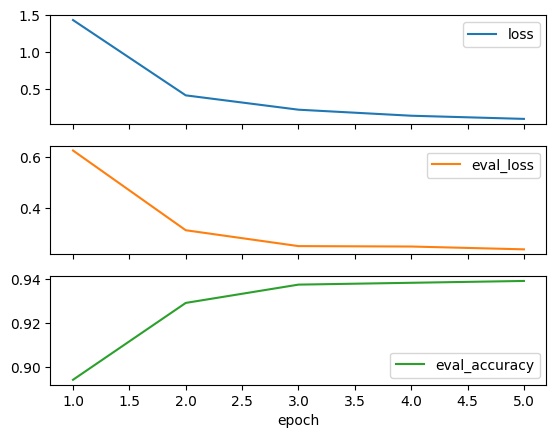

In [54]:
log_history[["loss", "eval_loss", "eval_accuracy"]].plot(subplots=True)

Hugging Face eğitim kümesine ait metrikleri döndürmediği için, en son elde edilen modeli tüm eğitim kümesi üzerinde çalıştırarak tanımladığımız metriklerin değerlerini elde edebiliriz:

In [55]:
metrics_training = trainer.evaluate(prepared_train)

In [56]:
metrics_training

{'eval_loss': 0.09327180683612823,
 'eval_accuracy': 0.9905882352941177,
 'eval_f1': 0.990587445420025,
 'eval_precision': 0.9906179579903401,
 'eval_recall': 0.9905882352941177,
 'eval_runtime': 992.092,
 'eval_samples_per_second': 6.854,
 'eval_steps_per_second': 0.215,
 'epoch': 5.0}

**EK NOT**

Eğitim kümesine ait metrikleri elde etmek için diğer bir yöntem `predict` methodunu kullanmaktır. Böylelikle, model tahminlerini alır ve bu tahminleri gerçek etiketlerle karşılaştırabiliriz.

```python
# Eğitim kümesi üzerinde yapılan tahminler
y_train_predict = trainer.predict(prepared_train)

# Tahminlere göz atalım
y_train_predict
```

Transfer öğrenme görüntü sınıflandırma modeli için tahmin edilen logitler, `predictions` metodu kullanılarak çıkarılabilir:

```python
# Tahmin edilen logitler
y_train_logits = y_train_predict.predictions

# İlk 5 görüntüye ait model çıktıları (logitler)
y_train_logits[:5]
```

Tahminin sekiz sütundan oluştuğunu görüyoruz. İlk sütun, etiket 0 için tahmin edilen logittir ve ikinci sütun, etiket 1 için tahmin edilen logittir ve bu böyle devam etmektedir. logit değerlerinin toplamı 1'e eşit değildir çünkü bu değerler normalleştirilmemiş olasılıklardır (diğer bir deyişle, model çıktısıdır). Çok-sınıflı sınıflandırma (multi-class classification) yaptığımız için Softmax fonksiyonu kullanarak bu değerleri normalleştirebiliriz:

```python
y_train_probabilities = torch.softmax(y_train_logits, dim = -1)
```

Softmax'ı uyguladıktan sonra, her görüntü için tahmin edilen olasılığın toplamının 1'e eşit olduğunu görebiliriz:

```python
# İlk 5 görüntüye ait normalleştirilmiş olasılıklar
y_train_probabilities[:5]
```

Tahmin edilen etiketleri elde etmek için, her görüntü için etiketlere karşılık gelen maksimum olasılık indeksini döndürmek üzere numpy kütüphanesinin `argmax` fonksiyonu kullanılır.

```python
# model tarafından eğitim kümesi üzerinde tahmin edilen etiketler
y_train_pred_labels = np.argmax(y_train_probabilities, axis=1)

# İlk 5 görüntüye ait tahmin edilen etiketler
y_train_pred_labels[:5]
```

Gerçek etiketler `y_train_predict.label_ids` kullanılarak çıkarılabilir.

```python
# Asıl Etiketler
y_train_actual_labels = y_train_predict.label_ids

# Eğitim kümesindeki ilk 5 görüntüye ait gerçek etiketler
y_train_actual_labels[:5]
```

Artık gerçek etiketleri (actual labels), eğitim kümesi üzerinde model tarafından tahmin edilen etiketler ile karşılaştırabiliriz.

Daha fazla model performans metriği hesaplamak için ilgilenilen metrikleri yüklemek amacıyla `evaluate.load`'u kullanabiliriz. Bu metrikleri zaten yukarıdaki hücrelerin birinde yüklemiştik:

```python
# Compute accuracy metric
print(accuracy_metric.compute(predictions=y_train_pred_labels, references=y_train_actual_labels))

# Compute f1 metric
print(f1_metric.compute(predictions=y_train_pred_labels, references=y_train_actual_labels, average="weighted"))

# Compute precision metric
print(precision_metric.compute(predictions=y_train_pred_labels, references=y_train_actual_labels, average="weighted"))

# Compute recall metric
print(recall_metric.compute(predictions=y_train_pred_labels, references=y_train_actual_labels, average="weighted"))
```

# En İyi Modeli Kaydetme

Artık sonuçlarımızdan memnun olduğumuza göre en iyi modeli kaydedebiliriz.

In [57]:
trainer.save_model(model_dir)

Yukarıdaki kod satırı hem modeli hem de modelle kullanılan öznitelik çıkarıcıyı (feature extractor) model dizinine kayıt edecektir.

Ancak, sadece öznitelik çıkarıcıyı kaydetmek isterseniz `feature_extractor.save_pretrained(model_dir)` kodunu kullanabilirsiniz. Bu kod sadece `preprocessor_config.json` dosyasını kaydedecektir.

Sonunda ince ayar çekilmiş ViT modeline sahibiz! WOHOO!

# Modeli Test Kümesi Üzerinde Değerlendirme

Şimdi test kümesindeki performansını doğrulamamız ve değerlendirme sonuçlarını (evaluation results) kaydetmemiz gerekmektedir.

**NOTE**: `trainer.evaluate()` test kümesi üzerinde etiketleri yapar ve metrikleri hesaplar, `trainer.predict()` ise sadece test kümesi üzerinde etiketleri tahmin eder.

In [58]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9392
  eval_f1                 =     0.9391
  eval_loss               =     0.2383
  eval_precision          =     0.9399
  eval_recall             =     0.9392
  eval_runtime            = 0:03:29.80
  eval_samples_per_second =       5.72
  eval_steps_per_second   =      0.181


`save_metrics` fonksiyonu test kümesi üzerinde değerlendirilen modelin sonuçlarını `model_dir` dizininin (bizim örneğimizde `./model` klasörü) altında `eval_results.json` olarak kaydedecektir.

Elde ettiğimiz modelin doğruluğu oldukça iyi.

İhtiyaç halinde test kümesinin ince-ayar çekilmiş model tarafından tahmin edilen etiketleri de elde edilebilir:

In [67]:
y_test_predict = trainer.predict(prepared_test)
y_test_predict

PredictionOutput(predictions=array([[-0.5574911 , -0.55256057, -0.44084704, ..., -0.6514604 ,
        -0.587717  ,  4.1993985 ],
       [ 4.004751  , -0.9422177 , -0.65568745, ..., -0.59566027,
        -0.17343669, -0.4465061 ],
       [-0.87891173, -1.0014176 ,  2.749767  , ...,  2.7222385 ,
        -1.0784245 , -0.91497976],
       ...,
       [-0.6408027 , -0.6666713 , -0.70249856, ..., -0.46141627,
        -0.4458719 , -0.84069437],
       [-0.6629647 , -0.72915053, -0.6185216 , ..., -0.6192481 ,
        -0.17926458, -0.71570873],
       [-0.6530872 , -0.67923456, -0.50120807, ..., -0.61496264,
        -0.73776233, -0.31934953]], dtype=float32), label_ids=array([7, 0, 5, ..., 4, 3, 3]), metrics={'test_loss': 0.23830144107341766, 'test_accuracy': 0.9391666666666667, 'test_f1': 0.9390956371766551, 'test_precision': 0.939918876802155, 'test_recall': 0.9391666666666667, 'test_runtime': 313.2723, 'test_samples_per_second': 3.831, 'test_steps_per_second': 0.121})

Transfer öğrenme görüntü sınıflandırma modeli için tahmin edilen logitler, `predictions` metodu kullanılarak çıkarılabilir:

In [68]:
# Tahmin edilen logitler
y_test_logits = y_test_predict.predictions

# İlk 5 görüntüye ait model çıktıları (logitler)
y_test_logits[:5]

array([[-0.5574911 , -0.55256057, -0.44084704, -0.43077588, -0.69217765,
        -0.6514604 , -0.587717  ,  4.1993985 ],
       [ 4.004751  , -0.9422177 , -0.65568745, -0.64027154, -0.7201288 ,
        -0.59566027, -0.17343669, -0.4465061 ],
       [-0.87891173, -1.0014176 ,  2.749767  , -0.8135734 , -1.0272567 ,
         2.7222385 , -1.0784245 , -0.91497976],
       [-0.44040072, -0.60538346, -0.6533643 , -0.5478527 , -0.48782963,
        -0.50029   ,  4.1607065 , -0.6397783 ],
       [-0.66559803, -0.6086572 , -0.5033142 , -0.36208436, -0.53697765,
        -0.7260709 , -0.3696426 ,  4.2133403 ]], dtype=float32)

Tahminin sekiz sütundan oluştuğunu görüyoruz. İlk sütun, etiket 0 için tahmin edilen logittir ve ikinci sütun, etiket 1 için tahmin edilen logittir ve bu böyle devam etmektedir. logit değerlerinin toplamı 1'e eşit değildir çünkü bu değerler normalleştirilmemiş olasılıklardır (diğer bir deyişle, model çıktısıdır). Çok-sınıflı sınıflandırma (multi-class classification) yaptığımız için Softmax fonksiyonunu kullanarak bu değerleri normalleştirebiliriz:

In [71]:
y_test_probabilities = torch.softmax(torch.tensor(y_test_logits), dim = 1)

Softmax'ı uyguladıktan sonra, her görüntü için tahmin edilen olasılıkların toplamının 1'e eşit olduğunu görebiliriz:

In [72]:
# İlk 5 görüntüye ait normalleştirilmiş olasılıklar
y_test_probabilities[:5]

tensor([[0.0081, 0.0081, 0.0091, 0.0092, 0.0071, 0.0074, 0.0079, 0.9431],
        [0.9328, 0.0066, 0.0088, 0.0090, 0.0083, 0.0094, 0.0143, 0.0109],
        [0.0125, 0.0111, 0.4714, 0.0134, 0.0108, 0.4586, 0.0103, 0.0121],
        [0.0094, 0.0080, 0.0076, 0.0085, 0.0090, 0.0089, 0.9408, 0.0077],
        [0.0072, 0.0076, 0.0084, 0.0097, 0.0082, 0.0067, 0.0096, 0.9426]])

Tahmin edilen etiketleri elde etmek için, her görüntü için etiketlere karşılık gelen maksimum olasılık indeksini döndürmek üzere NumPy kütüphanesinin `argmax` fonksiyonu kullanılır.

In [73]:
# model tarafından eğitim kümesi üzerinde tahmin edilen etiketler
y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)

# İlk 5 görüntüye ait tahmin edilen etiketler
y_test_pred_labels[:5]

tensor([7, 0, 2, 6, 7])

Gerçek etiketler `y_test_predict.label_ids` kullanılarak çıkarılabilir.

In [74]:
# Asıl Etiketler
y_test_actual_labels = y_test_predict.label_ids

# Eğitim kümesindeki ilk 5 görüntüye ait gerçek etiketler
y_test_actual_labels[:5]

array([7, 0, 5, 6, 7])

Artık gerçek etiketleri (actual labels), eğitim kümesi üzerinde model tarafından tahmin edilen etiketler ile karşılaştırabiliriz.

Daha fazla model performans metriği hesaplamak için ilgilenilen metrikleri yüklemek amacıyla `evaluate.load`'u kullanabiliriz. Bu metrikleri zaten yukarıdaki hücrelerin birinde yüklemiştik:

In [75]:
# Compute accuracy metric
print(accuracy_metric.compute(predictions=y_test_pred_labels, references=y_test_actual_labels))

# Compute f1 metric
print(f1_metric.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average="weighted"))

# Compute precision metric
print(precision_metric.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average="weighted"))

# Compute recall metric
print(recall_metric.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average="weighted"))

{'accuracy': 0.9391666666666667}
{'f1': 0.9390956371766551}
{'precision': 0.939918876802155}
{'recall': 0.9391666666666667}


Kolaylıkla anlaşılacağı üzere elde edilen sonuçlar, `trainer.evaluate(prepared_test)` kod satırının döndürdüğü sonuçlar ile aynıdır!

# Tek Bir Görüntü Üzerinde Modelin Tahmini

Şimdi de rastgele bir örneğe bakalım. Test veri kümemizdeki bir görseli seçip tahmin edilen etiketin doğru olup olmadığını görebiliriz.

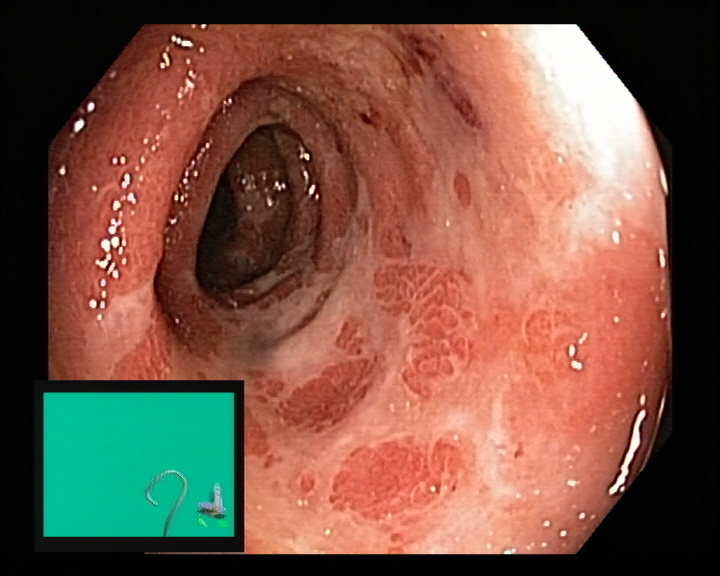

In [59]:
image = test_dataset["image"][0]
image

Asıl etiketi (actual label) çıkaralım.

In [60]:
# extract the actual label of the first image of the testing dataset
actual_label = id2label[str(test_dataset["label"][0])]
actual_label

'ulcerative-colitis'

Görüntünün bir `ulcerative-colitis` sınıfına ait olduğunu görüyoruz. Şimdi modelimizin ne tahmin ettiğini görelim.

Bunun için modelimizi bir daha yüklüyoruz:

In [61]:
model_finetuned = ViTForImageClassification.from_pretrained(model_dir)
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_dir)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [62]:
model_finetuned

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [63]:
feature_extractor_finetuned

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Daha sonra orijinal test görüntüsünü eğittiğimiz modele ait öznitelik çıkarıcıdan (feature extractor) geçiriyoruz ve elde edilen tensörü modelimize besliyoruz.

Burada `no_grad`, yalnızca çıkarsama (inference) yaptığımız için gradyan hesaplamasını devre dışı bırakan bir bağlam yöneticisidir.

In [64]:
inputs = feature_extractor_finetuned(image, return_tensors="pt")

with torch.no_grad():
    logits = model_finetuned(**inputs).logits

logits

tensor([[-0.5575, -0.5526, -0.4408, -0.4308, -0.6922, -0.6515, -0.5877,  4.1994]])

Elde edilen tensor her 8 sınıfa ait lojit değerleridir.

Logitler üzerinde NumPy kütüphanesinin `argmax` fonksiyonunu çağırdığımızda, en yüksek olasılığa sahip sınıfın indeksini alırsınız:

In [65]:
predicted_label = logits.argmax(-1).item()
predicted_label

7

In [66]:
predicted_class = id2label[str(predicted_label)]
predicted_class

'ulcerative-colitis'

İnce ayar çekilmiş modelin tahmini de `ulcerative-colitis`! Tam da beklediğimiz gibi!

# İnce Ayar Çekilmiş Modeli Hugging Face Hub'a Push'lamak

Modelimizin değerlendirme aşamasını da tamamladıktan sonra başkaları tarafından kullanılmak üzere Hugging Face'in Hub'ına push'layabiliriz!

In [76]:
notebook_login()

` notebook_login()` fonksiyonunu çalıştırdıktan sonra sizden bir token oluşturmanızı ve bu oluşturduğunuz token'ı ekrana girmenizi isteyecektir:

![](https://github.com/mmuratarat/turkish/blob/master/_posts/images/huggingface_notebook_login.png?raw=true)

Token oluşturmak için https://huggingface.co/settings/tokens sayfasına gidiniz, `New Token` butonuna tıklayınız. Token ismini (`Name`) giriniz. `Role` olarak da `write` seçmeyi unutmayınız. Çünkü daha sonra Hugging Face Hub'da bir repo oluşturacağız ve bu repoya dosyaları ekleyebilmek için yazma izinlerine (write permissions) sahip olmamız gerekmektedir:

![](https://github.com/mmuratarat/turkish/blob/master/_posts/images/image_huggingface_token_creation.png?raw=true)

Token'ı ilgili boşluğa girip `Login` butonuna bastığınız zaman `Login successful` çıktısını aldığınızdan emin olunuz:

![](https://github.com/mmuratarat/turkish/blob/master/_posts/images/huggingface_login_success.png?raw=true)

Notebook üzerinden Hugging Face ortamına giriş yaptıktan sonra, ilk olarak Hub'da bir depo (respository) oluşturmamız gerekmektedir. `create_repo` fonksiyonuna kullanıcı adınızı ve oluşturacağınız deponun ismini girmeniz istenir:

In [77]:
create_repo("mmuratarat/kvasir-v2-classifier", private=False)

RepoUrl('https://huggingface.co/mmuratarat/kvasir-v2-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='mmuratarat/kvasir-v2-classifier')

Depoyu oluşturduktan sonra artık Kvasir veri kümesi için ince ayar çektiğimiz Visual Transformer modelini Hub'a gönderebiliriz (push'layabiliriz):

In [78]:
model_finetuned.push_to_hub("mmuratarat/kvasir-v2-classifier")
feature_extractor_finetuned.push_to_hub("mmuratarat/kvasir-v2-classifier")

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mmuratarat/kvasir-v2-classifier/commit/800959d41a2f36ff47e91e8bc42f49bb7b6b8ad2', commit_message='Upload feature extractor', commit_description='', oid='800959d41a2f36ff47e91e8bc42f49bb7b6b8ad2', pr_url=None, pr_revision=None, pr_num=None)

Artık modelimizi herkes kolaylıkla kullanabilir.

Modelin sayfasına https://huggingface.co/mmuratarat/kvasir-v2-classifier bağlantısından ulaşabilirsiniz.

**NOT**: Bu yöntem otomatik bir model kartı yaratmaz. Bu nedenle, başkalarının sizin çalışmanızı kolay anlaması için bir model kartı yaratmayı unutmayın!

# Hugging Face'in Auto Sınıflarını Kullanarak Hub'daki İnce Ayar Çekilmiş Modele Erişmek

Artık Hugging Face'in Auto sınıflarını kullanabiliriz - https://huggingface.co/docs/transformers/v4.33.3/en/model_doc/auto#auto-classes

Çoğu durumda kullanmak istediğiniz mimari, `from_pretrained()` yöntemine sağladığınız önceden eğitilmiş modelin adından (name) veya yolundan (path) tahmin edilebilir.

Auto sınflar bu işi sizin için yapmak için buradalar; böylelikle, adı/yolu verilen önceden-eğitilmiş (pre-trained) ilgili modeli ve bu modelin önceden-eğitilmiş ağırlıklarını (weights), konfigürasyonlarını (config) ve kelime hazinesini (vocabuları) otomatik olarak alırsınız.

`AutoModelForImageClassification` sınıfı ile elde ettiğimiz modeli Hub'dan istediğimiz zaman çekerek çıkarsamalar yapabiliriz. Ancak girdi görüntülerini önce bir öznitelik çıkarıcıdan geçirmemiz gerekmektedir. Bunu ise `AutoFeatureExtractor` sınıfı ile gerçekleştirebiliriz. Sonuçta eğittiğimiz modelde kullanılan öznitelik çıkarıcı (feature extractor) model ile birlikte `preprocessor_config.json` isimli bir JSON dosyasına kaydedildi ve Hub'a gönderildi.

Buraya not düşülmesi gereken bir başka konu ise, modeli eğitirken kullanılan argümanların da bir JSON dosyası olarak kaydedildiğidir. Bu dosya bir konfigurasyon dosyasıdır ve `config.json` ismiyle bir JSON dosyası ile model dizinin altına kaydedilmiş ve Hub'a gönderilmiştir.


In [79]:
model = AutoModelForImageClassification.from_pretrained("mmuratarat/kvasir-v2-classifier")
feature_extractor = AutoFeatureExtractor.from_pretrained("mmuratarat/kvasir-v2-classifier")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [80]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [81]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Test kümesindeki 582. görüntüyü alalım:

In [82]:
image = test_dataset["image"][582]
actual_label = id2label[str(test_dataset["label"][582])]
actual_label

'normal-z-line'

Bu görüntünün gerçek sınıfı `normal-z-line`'dır.

Şimdi indirdiğimiz modelin tahminin elde edelim:

In [83]:
inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
predicted_class = id2label[str(predicted_label)]
predicted_class

'normal-z-line'

Doğru cevap!